


https://challengedata.ens.fr/en/challenge/39/prediction_of_transaction_claims_status.html

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import featuretools as ft
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import os

In [2]:
RANDOM_SEED = 42;
np.random.seed(RANDOM_SEED)

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

In [5]:
def load_data(file,data_path=DATA_PATH, sep=','):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path, sep)

In [6]:
TX_data = load_data(file = "input_train.csv");
STA_data = load_data(file = "challenge_output_data_training_file_prediction_of_transaction_claims_status.csv", sep=';');

In [7]:
TX_data = pd.merge(TX_data, STA_data, left_index=True, right_index=True)
#TX_data.drop(["ID_y","ID_x"],inplace=True,axis=1)
TX_data.drop(["ID_y"],inplace=True,axis=1)

In [8]:
del STA_data

In [9]:
#TX_data.head()

In [10]:
#TX_data["CLAIM_TYPE"].value_counts().head(10).plot.bar()

In [11]:
#TX_data.info()

In [12]:
def splitter(data, list_col):
    for colname in list_col:
        toto= data[colname].str.split('<', 1, expand=True)
        data[colname+"_MIN"] = toto[0]
        data[colname+"_MAX"] = toto[1]
        data[colname+"_MIN"]=data[colname+"_MIN"].str.replace('>',"")
        data.drop(colname, axis=1, inplace=True)

In [13]:
list_col_split=["WARRANTIES_PRICE",'SELLER_SCORE_COUNT','ITEM_PRICE','PURCHASE_COUNT','SHIPPING_PRICE']

In [14]:
splitter(TX_data,list_col_split)

In [15]:
TX_data.head()

,ID_x,SHIPPING_MODE,WARRANTIES_FLG,CARD_PAYMENT,COUPON_PAYMENT,RSP_PAYMENT,WALLET_PAYMENT,PRICECLUB_STATUS,REGISTRATION_DATE,BUYER_BIRTHDAY_DATE,...,WARRANTIES_PRICE_MIN,WARRANTIES_PRICE_MAX,SELLER_SCORE_COUNT_MIN,SELLER_SCORE_COUNT_MAX,ITEM_PRICE_MIN,ITEM_PRICE_MAX,PURCHASE_COUNT_MIN,PURCHASE_COUNT_MAX,SHIPPING_PRICE_MIN,SHIPPING_PRICE_MAX
0,0,NORMAL,False,1,0,1,0,UNSUBSCRIBED,2015,1992.0,...,NaN,NaN,10000,100000,,10,,5,NaN,NaN
1,1,NORMAL,False,1,0,0,0,UNSUBSCRIBED,2013,1952.0,...,NaN,NaN,10000,100000,,10,,5,NaN,NaN
2,2,NORMAL,False,0,0,0,1,PLATINUM,2013,1991.0,...,NaN,NaN,10000,100000,,10,50,100,NaN,NaN
3,3,RECOMMANDE,True,1,0,0,0,UNSUBSCRIBED,2007,1955.0,...,5,20,10000,100000,50,100,500,None,NaN,NaN
4,4,RECOMMANDE,False,1,0,1,0,PLATINUM,2010,1984.0,...,NaN,NaN,1000,10000,1000,5000,5,20,NaN,NaN


In [16]:
toto= TX_data['BUYING_DATE'].str.split('/', 1, expand=True)
TX_data['BUYING_DATE_Month'] = toto[0]
TX_data['BUYING_DATE_Year'] = toto[1]

In [17]:
del toto;

In [18]:
TX_data=TX_data.apply(pd.to_numeric, errors='ignore')

# Feature Engineering

## Taux de couverture de la garantie

In [19]:
TX_data["WARRANTIES_COVERAGE_MIN"]=TX_data["WARRANTIES_PRICE_MIN"]*TX_data["ITEM_PRICE_MIN"]*0.01
TX_data["WARRANTIES_COVERAGE_MAX"]=TX_data["WARRANTIES_PRICE_MAX"]*TX_data["ITEM_PRICE_MAX"]*0.01

## Is Claim

Attention, c'est un peu dangereux d'utiliser la target variable pour faire du feature engineering.

Il ne faut l'utiliser que pour faire des stats par clients & vendeurs, et l'ejecter tout aussi tôt

In [20]:
def b(row):
        return 0 if row['CLAIM_TYPE'] == '-' else 1;

In [21]:
TX_data['IS_CLAIM'] = TX_data.apply(b, axis=1)

## Shipping Method

Regroupement des méthodes de shipping rares sous la même catégorie.

Objectif = Diminuer la complexité de la variable

In [22]:
#TX_data["SHIPPING_MODE"].value_counts().head(10).plot.bar()

In [23]:
list_rare_delivery_type= ['EXPRESS_DELIVERY', 
                          'SO_RECOMMANDE', 
                          'MONDIAL_RELAY', 
                          'MONDIAL_RELAY_PREPAYE',
                          'SO_POINT_RELAIS', 
                          'CHRONOPOST', 
                          'PICKUP', 
                          'Kiala']
TX_data["SHIPPING_MODE"].replace(to_replace=list_rare_delivery_type, 
                                 value="RARE_TYPE", 
                                 inplace=True)

## Customer Premium

Regroupement des types de comptes payant sous la même catégorie.

Objectif = Diminuer la complexité de la variable

In [24]:
#TX_data["PRICECLUB_STATUS"].value_counts().head(10).plot.bar()

In [25]:
list_rare_delivery_type= ['PLATINUM', 
                          'SILVER', 
                          'GOLD']
TX_data["PRICECLUB_STATUS"].replace(to_replace=list_rare_delivery_type, 
                                 value="PREMIUM", 
                                 inplace=True)

## Trajet Interne

Flag pour signaler un envoi non international

Objectif = souligner les courts trajets

In [26]:
#TX_data["SELLER_COUNTRY"].value_counts().head(10).plot.bar()

In [27]:
def f(row):
        return 1 if row['SELLER_COUNTRY'] == 'FRANCE, METROPOLITAN' else 0;

In [28]:
TX_data['FROM_FRANCE'] = TX_data.apply(f, axis=1)

## Type de produit

To do : Détecter les produits fragiles

Objectif = souligner cet effet

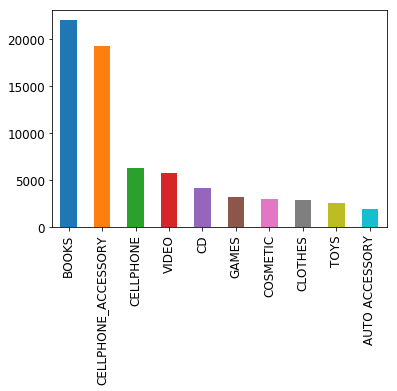

In [29]:
TX_data["PRODUCT_TYPE"].value_counts().head(10).plot.bar()

In [30]:
description_product_type=TX_data['IS_CLAIM'].groupby(TX_data['PRODUCT_TYPE']).describe().reset_index()

In [31]:
colnames_product_type=["PRODUCT_TYPE","Count_product_type","Mean_Claims_product_type","STD_Claims_product_type","t_1","t_2","t_3","t_4","t_5"]

description_product_type.columns=colnames_product_type
description_product_type.drop(["t_1","t_2","t_3","t_4","t_5"],axis=1,inplace=True)
description_product_type["Count_Claims_product_type"]=description_product_type["Mean_Claims_product_type"]*description_product_type["Count_product_type"]

In [32]:
TX_data=pd.merge(TX_data, description_product_type, on='PRODUCT_TYPE', how='outer')

## Création d'un ID par client 

Objectif = créer une base de données client

In [33]:
import hashlib

In [34]:
def idBuyerCreator(row):
        return hashlib.md5(
            (str(row['REGISTRATION_DATE'])+
             str(row["BUYER_DEPARTMENT"])+
             str(row["BUYER_BIRTHDAY_DATE"])
            ).encode()
        ).hexdigest()

In [35]:
TX_data['BUYER_ID'] = TX_data.apply(idBuyerCreator, axis=1)

## Calcul du taux de claims par client

Objectif = Créer de nouvelles features

In [36]:
description_buyer=TX_data['IS_CLAIM'].groupby(TX_data['BUYER_ID']).describe().reset_index()

In [37]:
colnames_buyer=["BUYER_ID","Count_Buys","Mean_Claims_Buys","STD_Claims_Buys","t_1","t_2","t_3","t_4","t_5"]

description_buyer.columns=colnames_buyer
description_buyer.drop(["t_1","t_2","t_3","t_4","t_5"],axis=1,inplace=True)
description_buyer["Count_Claims_Buy"]=description_buyer["Mean_Claims_Buys"]*description_buyer["Count_Buys"]

In [38]:
description_buyer.head()

,BUYER_ID,Count_Buys,Mean_Claims_Buys,STD_Claims_Buys,Count_Claims_Buy
0,000053139cdf7ed9ffb0a711efb13967,1.0,0.00,NaN,0.0
1,0003c35e39322d790554cf7138bfb1ec,4.0,0.75,0.5,3.0
2,00058c82bd3f21436121bb513a480d6d,1.0,1.00,NaN,1.0
3,000759550bd8e1c9af6547e943ac76bd,2.0,0.00,0.0,0.0
4,000a4cd562abc96382d3c1e15202b8ca,2.0,1.00,0.0,2.0


In [39]:
TX_data=pd.merge(TX_data, description_buyer, on='BUYER_ID', how='outer')

## Création d'un ID par vendeur

Objectif = créer une base de données vendeur

In [40]:
def idSellCreator(row):
        return hashlib.md5(
            (str(row["SELLER_COUNTRY"])+
             str(row["SELLER_DEPARTMENT"])+
             str(row["SELLER_SCORE_AVERAGE"])
            ).encode()
        ).hexdigest()

In [41]:
TX_data['SELLER_ID'] = TX_data.apply(idSellCreator, axis=1)

In [42]:
len(TX_data['SELLER_ID'].unique())

805

## Calcul du taux de claims par vendeur

Objectif = Créer de nouvelles features

In [43]:
description_sellers=TX_data['IS_CLAIM'].groupby(TX_data['SELLER_ID']).describe().reset_index()

In [44]:
colnames_sell=["SELLER_ID","Count_Sells","Mean_Claims_Sells","STD_Claims_Sells","t_1","t_2","t_3","t_4","t_5"]

description_sellers.columns=colnames_sell
description_sellers.drop(["t_1","t_2","t_3","t_4","t_5"],axis=1,inplace=True)
description_sellers["Count_Claims_Sells"]=description_sellers["Mean_Claims_Sells"]*description_sellers["Count_Sells"]

In [45]:
TX_data=pd.merge(TX_data, description_sellers, on='SELLER_ID', how='outer')

## Fusion des bases de données

Objectif = Yolo

In [46]:
list_to_drop=["ID_x","IS_CLAIM","BUYER_ID","SELLER_ID"]

In [47]:
TX_data.drop(list_to_drop,inplace=True,axis=1)

## On coupe

Objectif = Créer un jeu de données train et test

In [48]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(TX_data, 
                                       test_size=0.2, 
                                       random_state=RANDOM_SEED, 
                                       stratify=TX_data["CLAIM_TYPE"]
                                      )

## Preprocess

Objectif = Rendre joli tout ça

In [49]:
def datapreprocess(data):
    data=data.apply(pd.to_numeric, errors='ignore')
    
    # Y and X
    Y=data["CLAIM_TYPE"]
    X=data.drop("CLAIM_TYPE", axis=1,inplace=False)
    # Exclude Objets
    X=X.select_dtypes(exclude=['object'])
    
    # Work on fare
    from sklearn.preprocessing import Imputer
    imp = Imputer(missing_values='NaN',strategy='median', axis=1)
    X=pd.DataFrame(imp.fit_transform(X),columns=X.columns.values)
 
    return X, Y

In [50]:
X_train,Y_train=datapreprocess(train_set)
X_test, Y_test=datapreprocess(test_set)

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
rnd_clf = RandomForestClassifier(n_estimators=500, 
                                 max_leaf_nodes=16, 
                                 n_jobs=-1, 
                                 random_state=RANDOM_SEED)

In [53]:
rnd_clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [54]:
y_pred_rf = rnd_clf.predict(X_test)

In [55]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix score :\n {}".format(confusion_matrix(Y_test, y_pred_rf)))

Confusion matrix score :
 [[9840    0    0    0  121   35    0    0]
 [ 828    0    0    0  261   95    0    0]
 [ 599    0    0    0  165   92    0    0]
 [  13    0    0    0   18    2    0    0]
 [1802    0    0    0  932  228    0    0]
 [1785    0    0    0  322  649    0    0]
 [ 540    0    0    0  212   61    0    0]
 [1029    0    0    0  200  171    0    0]]


In [56]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(truth, pred, average="weighted"):

    lb = LabelBinarizer()
    lb.fit(truth)

    truth = lb.transform(truth)
    pred = lb.transform(pred)

    return roc_auc_score(truth, pred, average=average)

In [57]:
multiclass_roc_auc_score(Y_test, y_pred_rf)

0.61237821042656759